In [1]:
#================1.retrieve data===========================
import sys
import os
import urllib.request
import getpass
import requests

def verify_datasize(filename, expected_bytes):
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print("Found and verified.", filename)
    else:
        raise Exception("Failed to veryfile file [{}], file_size [{}], expected_size [{}].".format(filename, statinfo.st_size, expected_bytes))

        
#Reports every 5% change in download progress
last_percent_reported = None
def download_progress_hook(count, blockSize, totalSize):
    global last_percent_reported
    percent = int(count * blockSize * 100) / totalSize
    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
        else:
            sys.stdout.write(".")
        sys.stdout.flush()
    last_percent_reported = percent

    
#download a file from url and check size
data_root = "." #data saved local directory

urls = [['https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/train.zip', 569918665],
      ['https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/test.zip',284478493]]
headers = {
    'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/59.0.3071.115 Safari/537.36'
}

def download_data_without_Authentication(url, expected_bytes, force=False):
    dest_filename = os.path.join(data_root,url.split('/')[-1])
    if force or not os.path.exists(dest_filename):
        print("Attempting to download data from :", url)
        urllib.request.urlretrieve(url, dest_filename, download_progress_hook)
        print("\nDownload completed!")
    verify_datasize(dest_filename, expected_bytes)
    return dest_filename

#first you must login to Kaggle, direct to the specific competition, and accept rules competition, or post will direct to rules page.
#eg:dogs-vs-cats's rule page is:https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/rules
def download_data_with_Authentication(url, expected_bytes, force=False):
    dest_filename = os.path.join(data_root, url.split('/')[-1])
    if force or not os.path.exists(dest_filename):
        print("Attempting to download data from :", url)
        user_name = input("Enter username:")
        pwd = getpass.getpass("Enter password:")
        authen_info = {'UserName':user_name, 'Password': pwd}
        
        #To go to the redirect url
        resp = requests.get(url, headers=headers)
        print("Redirected:", resp.url)

        #To login and get data
        resp = requests.post(resp.url, data = authen_info, headers=headers,stream=True)
        print("Redirected:", resp.url)
        print("Status:", resp.status_code)
        
        if resp.status_code == requests.codes.ok:
            f = open(dest_filename, 'wb')
            for chunk in resp.iter_content(chunk_size = 512 * 1024):# Reads 512KB at a time into memory
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
            f.close()
            print("\nDownload completed!")
        else:
            raise Exception("\nDownload failed")
        
    verify_datasize(dest_filename, expected_bytes)
    return dest_filename
   

train_filename = download_data_with_Authentication(urls[0][0], urls[0][1])
test_filename = download_data_with_Authentication(urls[1][0], urls[1][1])        

    

Found and verified. ./train.zip
Found and verified. ./test.zip


In [2]:
#=================2.unzip file and explore image files======================
import zipfile

def unzip_file(filename):
    file_to_unzip = zipfile.ZipFile(filename)
    file_to_unzip.extractall()
    file_to_unzip.close()
    print("Unzip file succeed.", filename)
    
unzip_file(train_filename)
unzip_file(test_filename)
    

Unzip file succeed. ./train.zip
Unzip file succeed. ./test.zip


In [1]:
import os
import shutil
from PIL import Image

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

def rebuild_dir(dir):
    if os.path.exists(dir):
        shutil.rmtree(dir)
    os.mkdir(dir)
        
def rearrange_data(category_name):
    if category_name not in categories:
        raise Exception("\n category [{}] not exists.", category_name)
        
    category_data_dir = cate_dat_dir + "/" + category_name
    rebuild_dir(category_data_dir)
    
    train_filenames = os.listdir('./train')
    train_category = filter(lambda x:x[:3].upper() ==category_name.upper() , train_filenames)
    train_count = 0
    for filename in train_category:
        train_count += 1
        shutil.copy("./train/" + filename, category_data_dir)
    return train_count
 
def get_image_properties(category_name):
    if category_name not in categories:
        raise Exception("\n category {{}] not exists.", category_name)
        
    category_map = {}
    path = cate_dat_dir + "/" + category_name + "/"
    filenames = os.listdir(path)
    for filename in filenames:
        im = Image.open(path + filename)
        category_map[filename] = [im.format, im.mode, im.width, im.height]
    return category_map
'''
rebuild_dir(dat_dir)
rebuild_dir(cate_dat_dir)
dog_counts = rearrange_data("dog")
cat_counts = rearrange_data("cat")
image_properties_dog = get_image_properties("dog")
image_properties_cat = get_image_properties("cat")
'''

'\nrebuild_dir(dat_dir)\nrebuild_dir(cate_dat_dir)\ndog_counts = rearrange_data("dog")\ncat_counts = rearrange_data("cat")\nimage_properties_dog = get_image_properties("dog")\nimage_properties_cat = get_image_properties("cat")\n'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

columns = ['format', 'mode', 'width', 'height']

df_dog = pd.DataFrame(image_properties_dog).transpose()
df_cat = pd.DataFrame(image_properties_cat).transpose()
df_dog.columns = columns
df_cat.columns = columns

print("\ndogs count : [{}]. cats count:[{}]".format(dog_counts, cat_counts))

print("\ndogs group by format, mode:")
print(df_dog.groupby(['format', 'mode'])['width'].count())
print("\ncats group by format, mode:")
print(df_cat.groupby(['format', 'mode'])['width'].count())


plt.figure(figsize=(16,16))
plt.subplot(2, 1, 1)
plt.scatter(x=df_dog['width'], y=df_dog['height'], s=10, marker=".", color='red')
plt.scatter(x=df_cat['width'], y=df_cat['height'], s=10, marker="*", color='blue')
plt.legend(['dogs','cats'], loc='center right')
plt.xlabel('widht')
plt.ylabel('height')
plt.title("image size")
plt.subplots_adjust(hspace = .5)

plt.subplot(2,1,2)
plt.boxplot([df_dog['width'], df_dog['height'], df_cat['width'], df_cat['height']], showmeans=True)
plt.xticks([1,2,3,4], ['dog-width', 'dog-height', 'cat-width', 'cat-height'])
#plt.subplots_adjust(hspace = .5)
plt.show()

print("\ndogs width max/min:\n",df_dog.loc[[df_dog['width'].idxmax(),df_dog['width'].idxmin()]])
print("\ndogs height max/min:\n",df_dog.loc[[df_dog['height'].idxmax(),df_dog['height'].idxmin()]])
print("\ncats width max/mai:\n",df_cat.loc[[df_cat['width'].idxmax(),df_cat['width'].idxmin()]])
print("\ncats height max/min:\n",df_cat.loc[[df_cat['height'].idxmax(),df_cat['height'].idxmin()]])

NameError: name 'image_properties_dog' is not defined

In [4]:
#========================3.split and preprocess data================================
import random

def split_train_valid(category_name, test_percent, random_seed=None, create_link=False):
    if category_name not in categories:
        raise Exception("\n category [{}] note exists.", category_name)
    if test_percent <=0 or test_percent >=1:
        raise Exception("\n test_percent must be in (0,1)")
        
    source_dir = cate_dat_dir + "/" + category_name + "/"
    dest_train_dir = train_dat_dir + "/" + category_name + "/"
    dest_valid_dir = valid_dat_dir + "/" + category_name + "/"
    
    filenames = os.listdir(source_dir)
    total_size = len(filenames)
    test_size = int(total_size * test_percent)
    train_size = total_size - test_size
    
    if not random_seed is None:
        random.seed(random_seed)
    random.shuffle(filenames)
    rebuild_dir(dest_train_dir)
    rebuild_dir(dest_valid_dir)
    for i in range(0, total_size):
        if i < test_size:
            dest_dir = dest_valid_dir
        else:
            dest_dir = dest_train_dir
        
        if create_link == True:
                os.symlink(source_dir + filenames[i], dest_dir + filenames[i])
        else:
                shutil.copy(source_dir + filenames[i], dest_dir)
                
    return train_size, test_size

rebuild_dir(train_dat_dir)
rebuild_dir(valid_dat_dir)
dog_train_size, dog_test_size = split_train_valid("dog", 0.3, 1234, False)
cat_train_size, cat_test_size = split_train_valid("cat", 0.3, 1234, False)


Using TensorFlow backend.


Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.
Epoch 1/50
17500/17500 [==============================] - 170s - loss: 0.6935 - acc: 0.5035 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 2/50
17500/17500 [==============================] - 157s - loss: 0.6930 - acc: 0.5138 - val_loss: 0.6831 - val_acc: 0.5533
Epoch 3/50
17500/17500 [==============================] - 158s - loss: 0.6862 - acc: 0.5656 - val_loss: 0.6825 - val_acc: 0.5696
Epoch 4/50
17500/17500 [==============================] - 157s - loss: 0.6807 - acc: 0.5622 - val_loss: 0.7509 - val_acc: 0.5569
Epoch 5/50
17500/17500 [==============================] - 159s - loss: 0.6623 - acc: 0.6087 - val_loss: 0.6600 - val_acc: 0.5805
Epoch 6/50
17500/17500 [==============================] - 158s - loss: 0.6222 - acc: 0.6610 - val_loss: 0.6332 - val_acc: 0.6543
Epoch 7/50
17500/17500 [==============================] - 158s - loss: 0.5924 - acc: 0.6881 - val_loss: 0.5898 - val_acc: 0.6757
Epoch 8/50
1

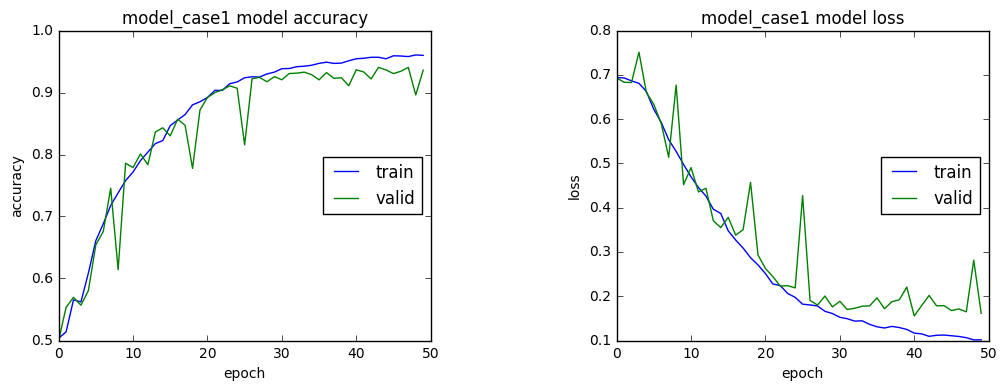

Found 12500 images belonging to 1 classes.
0 test/1.jpg
1 test/10.jpg
2 test/100.jpg
3 test/1000.jpg
4 test/10000.jpg
5 test/10001.jpg
6 test/10002.jpg
7 test/10003.jpg
8 test/10004.jpg
9 test/10005.jpg
10 test/10006.jpg
11 test/10007.jpg
12 test/10008.jpg
13 test/10009.jpg
14 test/1001.jpg
15 test/10010.jpg
16 test/10011.jpg
17 test/10012.jpg
18 test/10013.jpg
19 test/10014.jpg
20 test/10015.jpg
21 test/10016.jpg
22 test/10017.jpg
23 test/10018.jpg
24 test/10019.jpg
25 test/1002.jpg
26 test/10020.jpg
27 test/10021.jpg
28 test/10022.jpg
29 test/10023.jpg
30 test/10024.jpg
31 test/10025.jpg
32 test/10026.jpg
33 test/10027.jpg
34 test/10028.jpg
35 test/10029.jpg
36 test/1003.jpg
37 test/10030.jpg
38 test/10031.jpg
39 test/10032.jpg
40 test/10033.jpg
41 test/10034.jpg
42 test/10035.jpg
43 test/10036.jpg
44 test/10037.jpg
45 test/10038.jpg
46 test/10039.jpg
47 test/1004.jpg
48 test/10040.jpg
49 test/10041.jpg
50 test/10042.jpg
51 test/10043.jpg
52 test/10044.jpg
53 test/10045.jpg
54 test/1

In [ ]:
# model_case1 
import ModelUtil

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

total_train_size = 17500 #dog_train_size + cat_train_size
total_valid_size = 7500 #dog_test_size + cat_test_size
image_width=150
image_height=150
perbatch = 128
poch_num = 50

name_case1 = "model_case1"
model1= ModelUtil.model_case1(image_width, image_height)
model1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=["accuracy"])
ModelUtil.visualize_model(model1, model_name=name_case1)
history_case1 = ModelUtil.train_data(model1, model_name=name_case1, epoch=poch_num,
                          image_size = (image_width, image_height), num_perbatch=perbatch,
                          train_dir=train_dat_dir, train_size=total_train_size,
                          valid_dir=valid_dat_dir, valid_size=total_valid_size)
ModelUtil.visualize_history(history_case1, model_name=name_case1)
ModelUtil.predict_data(model1, model_name=name_case1, 
                 image_size=(image_width, image_height), 
                 num_perbatch=perbatch)
ModelUtil.save_model(model1, model_name=name_case1)

In [ ]:
#model_vgg19
import ModelUtil
dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

total_train_size = 17500 #dog_train_size + cat_train_size
total_valid_size = 7500 #dog_test_size + cat_test_size
image_width=200
image_height=200
image_size = (image_width,image_height)
perbatch = 128
poch_num = 20


name_vgg19 = "model_vgg19"
model_vgg19 = ModelUtil.model_vgg19(image_width, image_height)
model_vgg19.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
ModelUtil.visualize_model(model_vgg19, model_name=name_vgg19)
history_vgg19 = ModelUtil.train_data(model_vgg19, model_name=name_vgg19, epoch=poch_num,
                          image_size = (image_width, image_height), num_perbatch=perbatch,
                          train_dir=train_dat_dir, train_size=total_train_size,
                          valid_dir=valid_dat_dir, valid_size=total_valid_size)
ModelUtil.visualize_history(history_vgg19, model_name=name_vgg19)
ModelUtil.predict_data(model_vgg19, model_name=name_vgg19, 
                 image_size=(image_width, image_height), 
                 num_perbatch=perbatch)
ModelUtil.save_model(model_vgg19, model_name=name_vgg19)

Using TensorFlow backend.


Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.
Epoch 1/20


In [ ]:
#model_vgg16
import ModelUtil
dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

total_train_size = 17500 #dog_train_size + cat_train_size
total_valid_size = 7500 #dog_test_size + cat_test_size
image_width=224
image_height=224
image_size = (image_width,image_height)
perbatch = 64
poch_num = 20


name_vgg16 = "model_vgg16"
model_vgg16 = ModelUtil.model_vgg16(image_width, image_height)
model_vgg16.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
ModelUtil.visualize_model(model_vgg16, model_name=name_vgg16)
history_vgg16 = ModelUtil.train_data(model_vgg16, model_name=name_vgg16, epoch=poch_num,
                          image_size = (image_width, image_height), num_perbatch=perbatch,
                          train_dir=train_dat_dir, train_size=total_train_size,
                          valid_dir=valid_dat_dir, valid_size=total_valid_size)
ModelUtil.visualize_history(history_vgg16, model_name=name_vgg16)
ModelUtil.predict_data(model_vgg16, model_name=name_vgg16, 
                 image_size=(image_width, image_height), 
                 num_perbatch=perbatch)
ModelUtil.save_model(model_vgg16, model_name=name_vgg16)

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.
Epoch 1/20
17472/17500 [============================>.] - ETA: 1s - loss: 7.9959 - acc: 0.5011

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.
Epoch 1/40
17500/17500 [==============================] - 278s - loss: 0.6588 - acc: 0.5923 - val_loss: 0.6397 - val_acc: 0.6248
Epoch 2/40
17500/17500 [==============================] - 274s - loss: 0.6084 - acc: 0.6549 - val_loss: 0.5723 - val_acc: 0.6921
Epoch 3/40
17500/17500 [==============================] - 273s - loss: 0.5659 - acc: 0.7014 - val_loss: 0.5434 - val_acc: 0.7189
Epoch 4/40
17500/17500 [==============================] - 273s - loss: 0.5436 - acc: 0.7179 - val_loss: 0.5321 - val_acc: 0.7255
Epoch 5/40
17500/17500 [==============================] - 271s - loss: 0.5233 - acc: 0.7364 - val_loss: 0.5055 - val_acc: 0.7501
Epoch 6/40
17500/17500 [==============================] - 271s - loss: 0.4954 - acc: 0.7551 - val_loss: 0.5004 - val_acc: 0.7652
Epoch 7/40
17500/17500 [==============================] - 272s - loss: 0.4739 - acc: 0.7708 - val_loss: 0.4686 - val_acc: 0.7811
Epoch 8/40
1

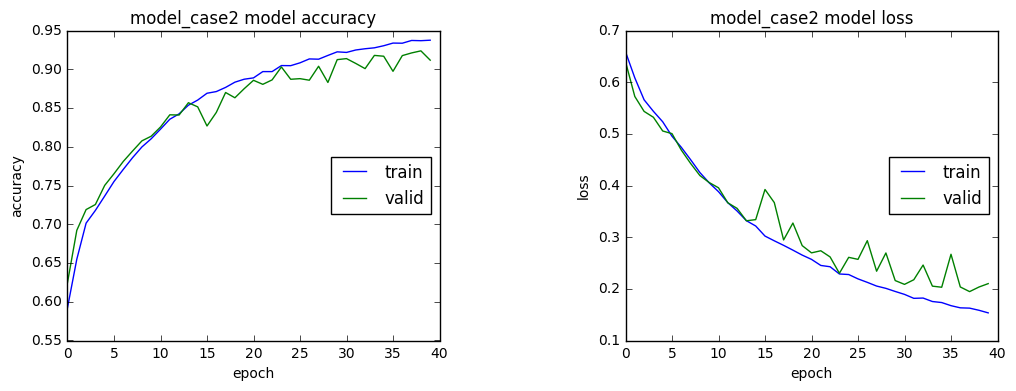

Found 12500 images belonging to 1 classes.


In [ ]:
#model_case2
import ModelUtil
from keras import optimizers

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

total_train_size = 17500 #dog_train_size + cat_train_size
total_valid_size = 7500 #dog_test_size + cat_test_size
image_width=224
image_height=224
image_size = (image_width,image_height)
perbatch = 32
poch_num = 40


name_case2 = "model_case2"
model_case2 = ModelUtil.model_mycase2(image_width, image_height)
rmsp = optimizers.rmsprop(lr=0.0001)
model_case2.compile(optimizer=rmsp, loss='binary_crossentropy', metrics=['accuracy'])
ModelUtil.visualize_model(model_case2, model_name=name_case2)
history_case2 = ModelUtil.train_data(model_case2, model_name=name_case2, epoch=poch_num,
                          image_size = (image_width, image_height), num_perbatch=perbatch,
                          train_dir=train_dat_dir, train_size=total_train_size,
                          valid_dir=valid_dat_dir, valid_size=total_valid_size)
ModelUtil.visualize_history(history_case2, model_name=name_case2)
ModelUtil.predict_data(model_case2, model_name=name_case2, 
                 image_size=(image_width, image_height), 
                 num_perbatch=perbatch)
ModelUtil.save_model(model_case2, model_name=name_case2)

In [1]:
#model_case2_tune
import ModelUtil
from keras import optimizers

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

total_train_size = 17500 #dog_train_size + cat_train_size
total_valid_size = 7500 #dog_test_size + cat_test_size
image_width=224
image_height=224
image_size = (image_width,image_height)
perbatch = 32
poch_num = 60


name_case2_tune = "model_case2_tune"
model_case2_tune = ModelUtil.model_mycase2(image_width, image_height)
rmsp = optimizers.rmsprop(lr=0.0001)
model_case2_tune.compile(optimizer=rmsp, loss='binary_crossentropy', metrics=['accuracy'])
ModelUtil.visualize_model(model_case2_tune, model_name=name_case2_tune)
history_case2_tune = ModelUtil.train_data(model_case2_tune, model_name=name_case2_tune, epoch=poch_num,
                          image_size = (image_width, image_height), num_perbatch=perbatch,
                          train_dir=train_dat_dir, train_size=total_train_size,
                          valid_dir=valid_dat_dir, valid_size=total_valid_size)
ModelUtil.visualize_history(history_case2_tune, model_name=name_case2_tune)
ModelUtil.predict_data(model_case2_tune, model_name=name_case2_tune, 
                 image_size=(image_width, image_height), 
                 num_perbatch=perbatch)
ModelUtil.save_model(model_case2_tune, model_name=name_case2_tune)

Using TensorFlow backend.


NameError: name 'name_case2' is not defined